# Height Above Ground
Let's begin to play around with filters.

Start by importing various packages.

In [1]:
%matplotlib inline

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pdal
from sklearn.neighbors.kde import KernelDensity
from six.moves.urllib.request import urlretrieve

If you've run the previous tutorials, then you probably already have the data, but if not, this will download some sample data.

In [2]:
url = 'https://github.com/PDAL/data/raw/master/isprs/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

# pc_filename = maybe_download('samp11-utm.laz', 99563)
pc_filename = maybe_download('CSite1_orig-utm.laz', 4539968)

('Found and verified', './CSite1_orig-utm.laz')


And define our function for plotting the kernel density estimation for a particular dimension.

In [3]:
def dim_kde_full(arr, n=500, bw=0.25, k='epanechnikov'):
    xp = np.linspace(arr.min(), arr.max(), n)[:, np.newaxis]
    kde = KernelDensity(kernel=k, bandwidth=bw).fit(arr[:, np.newaxis])
    log_pdf = kde.score_samples(xp)
    plt.plot(xp, np.exp(log_pdf))

In [4]:
def dim_kde(arr, lb, ub, n=500, bw=0.25, k='epanechnikov'):
    f = plt.figure()
    xp = np.linspace(lb, ub, n)[:, np.newaxis]
    kde = KernelDensity(kernel=k, bandwidth=bw).fit(arr[:, np.newaxis])
    log_pdf = kde.score_samples(xp)
    ax = f.add_subplot(111)
    ax.plot(xp, np.exp(log_pdf))

The first pipeline will apply the Simple Morphological Filter (SMRF) to segment ground (`Classification=2`) and non-ground (`Classification=1`). Next, the Height Above Ground (HAG) filter is applied to estimate each point's height above ground. This is done by compute the difference in elevation between the current point and the nearest ground point (searching only laterally).

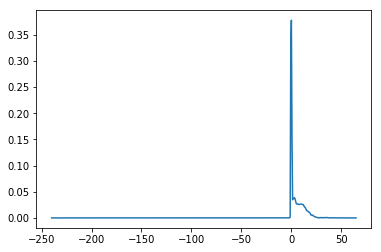

In [5]:
json = u'''
{
  "pipeline":[
    "%s",
    {
      "type":"filters.smrf"
    },
    {
      "type":"filters.hag"
    }
  ]
}''' % pc_filename

p = pdal.Pipeline(json)
p.validate()
count = p.execute()
data = p.arrays[0]
dim_kde_full(data['HeightAboveGround'],bw=1.0)

We see that the range of HAG values can be quite large, and that there is a large spike at 0. This corresponds to the ground returns themselves, where the HAG is 0. We may be more interested in visualizing the HAG of only the non-ground points. Adding a range filter that passes points with `Classification=1` accomplishes this.

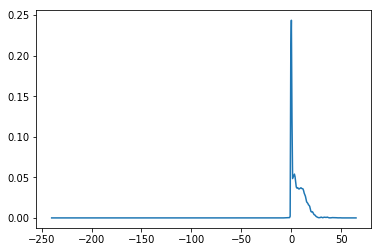

In [6]:
json = u'''
{
  "pipeline":[
    "%s",
    {
      "type":"filters.smrf"
    },
    {
      "type":"filters.hag"
    },
    {
      "type":"filters.range",
      "limits":"Classification[1:1]"
    }
  ]
}''' % pc_filename

p = pdal.Pipeline(json)
p.validate()
count = p.execute()
data = p.arrays[0]
dim_kde_full(data['HeightAboveGround'],bw=1.0)

Not sure this will work, but let's check to see if there appear to be a large number of low outliers.

In [7]:
json = u'''
{
  "pipeline":[
    "%s",
    {
      "type":"filters.elm"
    },
    {
      "type":"filters.range",
      "limits":"Classification[7:7]"
    }
  ]
}''' % pc_filename

p = pdal.Pipeline(json)
p.validate()
count = p.execute()
print(count, 'points labeled as low outliers')
# data = p.arrays[0]
# dim_kde_full(data['HeightAboveGround'],bw=1.0)

(318, 'points labeled as low outliers')


That certainly may be something, let's remove these points and continue with the pipeline. Notice that we have not only added the `elm` and `range` filters, but we've now negated the `DimRange` indicating that we want to proceed with only the points that are **not** low outliers.

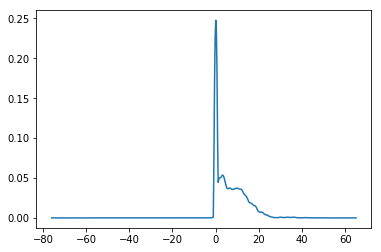

In [8]:
json = u'''
{
  "pipeline":[
    "%s",
    {
      "type":"filters.elm"
    },
    {
      "type":"filters.range",
      "limits":"Classification![7:7]"
    },
    {
      "type":"filters.smrf"
    },
    {
      "type":"filters.hag"
    },
    {
      "type":"filters.range",
      "limits":"Classification[1:1]"
    }
  ]
}''' % pc_filename

p = pdal.Pipeline(json)
p.validate()
count = p.execute()
data = p.arrays[0]
dim_kde_full(data['HeightAboveGround'],bw=1.0)

This is beginning to look better. Even now, we may be more interested in positive HAG values. Furthermore, let's cut out those points that are "near" ground. We will pass only those points with a HAG greater than 1.

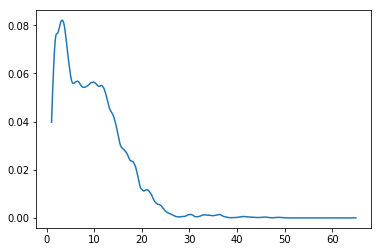

In [9]:
json = u'''
{
  "pipeline":[
    "%s",
    {
      "type":"filters.smrf"
    },
    {
      "type":"filters.hag"
    },
    {
      "type":"filters.range",
      "limits":"Classification[1:1],HeightAboveGround[1:]"
    }
  ]
}''' % pc_filename

p = pdal.Pipeline(json)
p.validate()
count = p.execute()
data = p.arrays[0]
dim_kde_full(data['HeightAboveGround'],bw=1.0)

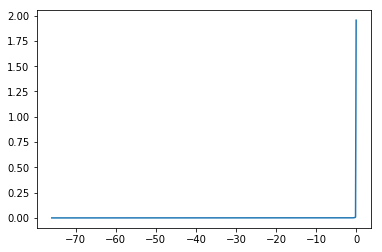

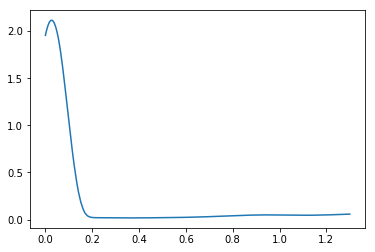

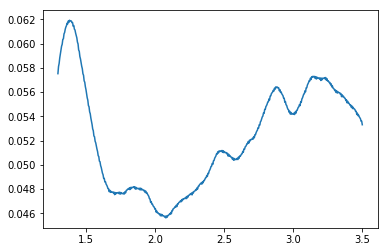

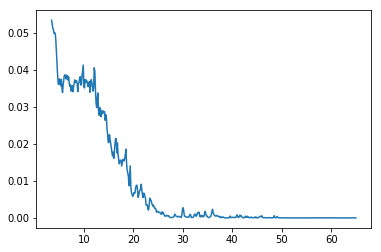

In [10]:
json = u'''
{
  "pipeline":[
    "%s",
    {
      "type":"filters.elm"
    },
    {
      "type":"filters.range",
      "limits":"Classification![7:7]"
    },
    {
      "type":"filters.smrf"
    },
    {
      "type":"filters.hag"
    },
    {
      "type":"filters.range",
      "limits":"Classification[1:1]"
    }
  ]
}''' % pc_filename

p = pdal.Pipeline(json)
p.validate()
count = p.execute()
data = p.arrays[0]
dim_kde(data['HeightAboveGround'],data['HeightAboveGround'].min(),0,bw=0.1)
dim_kde(data['HeightAboveGround'],0,1.3,bw=0.1)
dim_kde(data['HeightAboveGround'],1.3,3.5,bw=0.1)
dim_kde(data['HeightAboveGround'],3.5,data['HeightAboveGround'].max(),bw=0.1)